# Fibro-QuanNet NoteBook
Developed by: Nuvin Godakanda Arachchi


In [113]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import pydicom
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings
import pytest
import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *
import pennylane as qml
import math
import sklearn.metrics

from datetime import datetime, timedelta
from matplotlib import cm
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from torch.utils.data import Dataset
from tqdm import tqdm
from torch.utils.data import DataLoader, Subset
from tqdm import trange
from time import time
from scipy.ndimage.interpolation import zoom
from enum import Enum
from torchvision import transforms
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border

# Constants
n_qubits = 4
test_size=0.2
batch_size = 32
learning_rate = 1e-3
num_epochs = 30
quantiles = (0.2, 0.5, 0.8)
q_depth = 6

dev = qml.device("default.qubit", wires=n_qubits)
model_name ='prediction-model'
dataset = Path('osic-pulmonary-fibrosis-progression')
modelDirectory = Path('models')
dicom_encoder_weights = Path('dicom-utilities')/'dicom_encoder.pth'
cache_dataset = Path('osic-cached-dataset')
latent_dir = Path('latent')
latent_dir.mkdir(exist_ok=True, parents=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/var/folders/cv/02cll88d62506wtjxbvtw63h0000gn/T/ipykernel_72070/2434529649.py:28: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


## DICOM and tabular pre-processing

In [119]:
class OSICDataset(Dataset):

    def __init__(self, root, dicom_dir, mode, transform=None, cache_dir=None):

        self.transform = transform
        self.mode = mode
        self.dicom_dir = Path(dicom_dir)
        self.cache_dir = None if cache_dir is None else Path(cache_dataset)

        if cache_dir is not None:   # Utilize pre-processed data if cache available
            self.raw = pd.read_csv(self.cache_dir/f'tabular_{mode}.csv')
            with open(self.cache_dir/'features_list.pkl', "rb") as fp:
                self.FE = pickle.load(fp)
            return

        # If cache data is not available, proceed to pre-process
        training_data = pd.read_csv(Path(root)/"train.csv")
        training_data.drop_duplicates(keep=False, inplace=True, subset=['Patient', 'Weeks'])

        # Reading submission
        sub = pd.read_csv(Path(root)/"sample_submission.csv")
        sub['Patient'] = sub['Patient_Week'].apply(lambda x: x.split('_')[0])
        sub['Weeks'] = sub['Patient_Week'].apply(lambda x: int(x.split('_')[-1]))
        sub = sub[['Patient', 'Weeks', 'Confidence', 'Patient_Week']]

        chunk = pd.read_csv(Path(root)/"test.csv")
        sub = sub.merge(chunk.drop('Weeks', axis=1), on="Patient")

        training_data['WHERE'] = 'train'
        chunk['WHERE'] = 'val'
        sub['WHERE'] = 'test'
        data = training_data.append([chunk, sub])

        data['min_week'] = data['Weeks']
        data.loc[data.WHERE == 'test', 'min_week'] = np.nan
        data['min_week'] = data.groupby('Patient')['min_week'].transform('min')

        base = data.loc[data.Weeks == data.min_week]
        base = base[['Patient', 'FVC']].copy()
        base.columns = ['Patient', 'min_FVC']
        base['nb'] = 1
        base['nb'] = base.groupby('Patient')['nb'].transform('cumsum')
        base = base[base.nb == 1]
        base.drop('nb', axis=1, inplace=True)

        data = data.merge(base, on='Patient', how='left')
        data['base_week'] = data['Weeks'] - data['min_week']
        del base

        COLS = ['Sex', 'SmokingStatus']
        self.FE = []
        for col in COLS:
            for mod in data[col].unique():
                self.FE.append(mod)
                data[mod] = (data[col] == mod).astype(int)

        data['age'] = (data['Age'] - data['Age'].min()) / \
                      (data['Age'].max() - data['Age'].min())
        data['BASE'] = (data['min_FVC'] - data['min_FVC'].min()) / \
                       (data['min_FVC'].max() - data['min_FVC'].min())
        data['week'] = (data['base_week'] - data['base_week'].min()) / \
                       (data['base_week'].max() - data['base_week'].min())
        data['percent'] = (data['Percent'] - data['Percent'].min()) / \
                          (data['Percent'].max() - data['Percent'].min())
        self.FE += ['age', 'percent', 'week', 'BASE']

        self.raw = data.loc[data.WHERE == mode].reset_index()
        del data

    def __len__(self):
        return len(self.raw)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        patient_id = self.raw['Patient'].iloc[idx]
        if self.cache_dir is None:
            patient_path = self.dicom_dir / patient_id
            image, metadata = load_scan(patient_path)
        else:
            image = torch.load(self.cache_dir / f'{patient_id}.pt')
            metadata = pydicom.read_file(self.cache_dir / f'{patient_id}.dcm')

        sample = {
            'features': self.raw[self.FE].iloc[idx].values,
            'image': image,
            'metadata': metadata,
            'target': self.raw['FVC'].iloc[idx]
        }
        if self.transform:
            sample = self.transform(sample)

        return sample

    def cache(self, cache_dir):
        Path(cache_dir).mkdir(exist_ok=True, parents=True)

        # Cache raw features table
        self.raw.to_csv(Path(cache_dir)/f'tabular_{self.mode}.csv', index=False)

        # Cache features list
        with open(Path(cache_dir)/'features_list.pkl', "wb") as fp:
            pickle.dump(self.FE, fp)

        # Cache images and metadata
        self.raw['index'] = self.raw.index
        idx_unique = self.raw.groupby('Patient').first()['index'].values
        bar = tqdm(idx_unique.tolist())
        for idx in bar:
            sample = self[idx]
            patient_id = sample['metadata'].PatientID
            torch.save(sample['image'], Path(cache_dir)/f'{patient_id}.pt')
            sample['metadata'].save_as(Path(cache_dir)/f'{patient_id}.dcm')

In [120]:
# Helper function that loads CT scans in a single array. 
# This is also new vs. baseline
def load_scan(path):
    slices = [pydicom.read_file(p) for p in path.glob('*.dcm')]
    try:
        slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    except AttributeError:
        warnings.warn(f'Patient {slices[0].PatientID} CT scan does not '
                      f'have "ImagePositionPatient". Assuming filenames '
                      f'in the right scan order.')

    image = np.stack([s.pixel_array.astype(float) for s in slices])
    return image, slices[0]

## Preprocessing CT Scans

## Bounding Boxes

In [10]:
class CropBoundingBox:
    @staticmethod
    def bounding_box(img3d: np.array):
        mid_img = img3d[int(img3d.shape[0] / 2)]
        same_first_row = (mid_img[0, :] == mid_img[0, 0]).all()
        same_first_col = (mid_img[:, 0] == mid_img[0, 0]).all()
        if same_first_col and same_first_row:
            return True
        else:
            return False

    def __call__(self, sample):
        image = sample['image']
        if not self.bounding_box(image):
            return sample

        mid_img = image[int(image.shape[0] / 2)]
        r_min, r_max = None, None
        c_min, c_max = None, None
        for row in range(mid_img.shape[0]):
            if not (mid_img[row, :] == mid_img[0, 0]).all() and r_min is None:
                r_min = row
            if (mid_img[row, :] == mid_img[0, 0]).all() and r_max is None \
                    and r_min is not None:
                r_max = row
                break

        for col in range(mid_img.shape[1]):
            if not (mid_img[:, col] == mid_img[0, 0]).all() and c_min is None:
                c_min = col
            if (mid_img[:, col] == mid_img[0, 0]).all() and c_max is None \
                    and c_min is not None:
                c_max = col
                break

        image = image[:, r_min:r_max, c_min:c_max]
        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

## Convert to Hounsfield Units

In [11]:
class ConvertToHU:
    def __call__(self, sample):
        image, data = sample['image'], sample['metadata']

        img_type = data.ImageType
        is_hu = img_type[0] == 'ORIGINAL' and not (img_type[2] == 'LOCALIZER')
        if not is_hu:
            warnings.warn(f'Patient {data.PatientID} CT Scan not cannot be'
                          f'converted to Hounsfield Units (HU).')

        intercept = data.RescaleIntercept
        slope = data.RescaleSlope
        image = (image * slope + intercept).astype(np.int16)
        return {
            'features': sample['features'],
            'image': image,
            'metadata': data,
            'target': sample['target']
        }

## Resize

In [12]:
class Resize:
    def __init__(self, output_size):
        assert isinstance(output_size, tuple)
        self.output_size = output_size

    def __call__(self, sample):
        image = sample['image']
        resize_factor = np.array(self.output_size) / np.array(image.shape)
        image = zoom(image, resize_factor, mode='nearest')
        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

## Clip

In [13]:
class Clip:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image = sample['image']
        image[image < self.min] = self.min
        image[image > self.max] = self.max
        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

## Mask

In [14]:
class Mask:
    def __init__(self, threshold=-400,
                 root='../data/test'):
        self.threshold = threshold
        self.root = root

    def __call__(self, sample):
        image = sample['image']
        for slice_id in range(image.shape[0]):
            m = self.get_morphological_mask(image[slice_id])
            image[slice_id][m == False] = image[slice_id].min()

        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

    def get_morphological_mask(self, image):
        m = image < self.threshold
        m = clear_border(m)
        m = label(m)
        areas = [r.area for r in regionprops(m)]
        areas.sort()
        if len(areas) > 2:
            for region in regionprops(m):
                if region.area < areas[-2]:
                    for coordinates in region.coords:
                        m[coordinates[0], coordinates[1]] = 0
        return m > 0

### Normalize, to tensor and zero center

In [15]:
class Normalize:
    def __init__(self, bounds=(-1000, 500)):
        self.min = min(bounds)
        self.max = max(bounds)

    def __call__(self, sample):
        image = sample['image'].astype(np.float)
        image = (image - self.min) / (self.max - self.min)
        return {
            'features': sample['features'],
            'image': image,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

class ToTensor:
    def __init__(self, add_channel=True):
        self.add_channel = add_channel

    def __call__(self, sample):
        image = sample['image']
        if self.add_channel:
            image = np.expand_dims(image, axis=0)

        return {
            'features': sample['features'],
            'image': torch.from_numpy(image),
            'metadata': sample['metadata'],
            'target': sample['target']
        }
    
class ZeroCenter:
    def __init__(self, pre_calculated_mean):
        self.pre_calculated_mean = pre_calculated_mean

    def __call__(self, sample):
        return {
            'features': sample['features'],
            'image': sample['image'] - self.pre_calculated_mean,
            'metadata': sample['metadata'],
            'target': sample['target']
        }

### Validating Pipeline

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Patient ID00421637202311550012437 CT Scan not cannot beconverted to Hounsfield Units (HU).
  


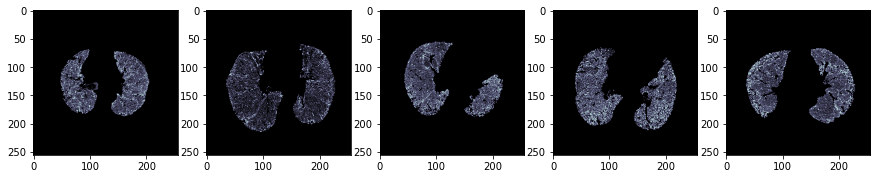

In [17]:
def show(list_imgs, cmap=cm.bone, rgb=False):
    list_slices = []
    for img3d in list_imgs:
        slc = int(img3d.shape[0] / 2)
        img = img3d[slc]
        if rgb:
            img = (img * 255).astype(np.int16)
        list_slices.append(img)

    fig, axs = plt.subplots(1, 5, figsize=(15, 7))
    for i, img in enumerate(list_slices):
        axs[i].imshow(img, cmap=cmap)

    plt.show()

data = OSICDataset(
    root=dataset,
    dicom_dir=dataset/'test',
    mode='val',
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize((40, 256, 256)),
        Clip(bounds=(-1000, 500)),
        Mask(threshold=-500),
        Normalize(bounds=(-1000, -500))
    ]))

for i in range(len(data)):
    assert data[i]['image'].shape == (40, 256, 256)
    
list_imgs = [data[i]['image'] for i in range(len(data))]
show(list_imgs)

# Models and Training

## Quantum Circuit

In [117]:
# Single qubit Hadamard Gates layer
def hadamard_layer(nqubits):
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)

# Rotates the parameterized qubits against the y-axis
def rotation_y_layer(w):
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangle_layer(nqubits):
    for i in range(0, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2):
        qml.CNOT(wires=[i, i + 1])

In [115]:
@qml.qnode(dev, interface="torch")
def variational_circuit(q_input_features, q_weights_flat):
    # Reshape weights
    q_weights = q_weights_flat.reshape(q_depth, n_qubits)

    # Start from state |+> , unbiased w.r.t. |0> and |1>
    hadamard_layer(n_qubits)

    # Embed features in the quantum node
    rotation_y_layer(q_input_features)

    # Sequence of trainable variational layers
    for k in range(q_depth):
        entangle_layer(n_qubits)
        rotation_y_layer(q_weights[k])

    # Expectation values in the Z basis
    exp_vals = [qml.expval(qml.PauliZ(position)) for position in range(n_qubits)]
    return tuple(exp_vals)

## Quantile Regression model

In [19]:
class RegressionModel(nn.Module):
    def __init__(self, in_tabular_features=9, in_ctscan_features=76800, out_quantiles=3):
        super(RegressionModel, self).__init__()
        self.in_ctscan_features = in_ctscan_features

        self.fc1 = nn.Linear(in_tabular_features, 512)
        self.fc2 = nn.Linear(in_ctscan_features, 512)
        self.fc3 = nn.Linear(1024, 512)
        self.fc4 = nn.Linear(512, out_quantiles)

    def forward(self, x1, x2):
        # Now the quant model has 2 inputs: x1 (the tabular features)
        # and x2 (the pre-computed latent features)
        x1 = F.relu(self.fc1(x1))

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 4
        pre_out = self.pre_net(x2)
        q_in = torch.tanh(pre_out) * np.pi / 2.0
        
        # Flattens the latent features and concatenate with tabular features
        x2 = x2.view(-1, self.in_ctscan_features)
        x2 = F.relu(self.fc2(x2))
        x = torch.cat([x1, x2], dim=1)

        # Apply the quantum circuit to each element of the batch and append to q_out
        q_out = torch.Tensor(0, n_qubits)
        q_out = q_out.to(device)
        for elem in q_in:
            q_out_elem = variational_circuit(elem, self.q_params).float().unsqueeze(0)
            q_out = torch.cat((q_out, q_out_elem))

        x = self.post_net(q_out)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

## Quantile Regression loss

In [20]:
def quantile_loss(preds, target, quantiles):
    assert not target.requires_grad
    assert preds.size(0) == target.size(0)
    losses = []
    for i, q in enumerate(quantiles):
        errors = target - preds[:, i]
        losses.append(torch.max((q - 1) * errors, q * errors).unsqueeze(1))
    loss = torch.mean(torch.sum(torch.cat(losses, dim=1), dim=1))
    return loss

## AutoEncoding Pre-processed DICOM

In [21]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        # Encoder
        self.conv1 = nn.Conv3d(1, 16, 3)
        self.conv2 = nn.Conv3d(16, 32, 3)
        self.conv3 = nn.Conv3d(32, 96, 2)
        self.pool1 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        self.pool2 = nn.MaxPool3d(kernel_size=3, stride=3, return_indices=True)
        self.pool3 = nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        # Decoder
        self.deconv1 = nn.ConvTranspose3d(96, 32, 2)
        self.deconv2 = nn.ConvTranspose3d(32, 16, 3)
        self.deconv3 = nn.ConvTranspose3d(16, 1, 3)
        self.unpool1 = nn.MaxUnpool3d(kernel_size=2, stride=2)
        self.unpool2 = nn.MaxUnpool3d(kernel_size=3, stride=3)
        self.unpool3 = nn.MaxUnpool3d(kernel_size=2, stride=2)

    def encode(self, x, return_partials=True):
        # Encoder
        x = self.conv1(x)
        up3out_shape = x.shape
        x, i1 = self.pool1(x)
        x = self.conv2(x)
        up2out_shape = x.shape
        x, i2 = self.pool2(x)
        x = self.conv3(x)
        up1out_shape = x.shape
        x, i3 = self.pool3(x)

        if return_partials:
            return x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3
        else:
            return x

    def forward(self, x):
        x, up3out_shape, i1, up2out_shape, i2, up1out_shape, i3 = self.encode(x)

        # Decoder
        x = self.unpool1(x, output_size=up1out_shape, indices=i3)
        x = self.deconv1(x)
        x = self.unpool2(x, output_size=up2out_shape, indices=i2)
        x = self.deconv2(x)
        x = self.unpool3(x, output_size=up3out_shape, indices=i1)
        x = self.deconv3(x)

        return x

## Cache all pre-processed 3D CT Scans and pre-compute all latent features

In [22]:
# Helper function that generates all latent features
class GenerateLatentFeatures:
    def __init__(self, autoencoder, latent_dir):
        self.autoencoder = autoencoder
        self.latent_dir = Path(latent_dir)
        self.cache_dir = Path(cache_dataset)

    def __call__(self, sample):
        patient_id = sample['metadata'].PatientID
        cached_latent_file = self.latent_dir/f'{patient_id}_lat.pt'

        if cached_latent_file.is_file():
            latent_features = torch.load(cached_latent_file)
        else:
            with torch.no_grad():
                img = sample['image'].float().unsqueeze(0)
                latent_features = self.autoencoder.encode(
                    img, return_partials=False).squeeze(0)
            torch.save(latent_features, cached_latent_file)

        return {
            'tabular_features': sample['features'],
            'latent_features': latent_features,
            'target': sample['target']
        }

In [ ]:
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load(
    dicom_encoder_weights,
    map_location=torch.device('cpu')
))
autoencoder.to(device)
autoencoder.eval()

data = OSICDataset(
    root=dataset,
    dicom_dir=dataset/'train',
    cache_dir=cache_dataset,
    mode='train',
    transform=GenerateLatentFeatures(autoencoder, latent_dir)
)
for i in trange(len(data)):
    sample = data[i]
    assert sample['latent_features'].shape == (96, 2, 20, 20)

# Training

In [25]:
# Group Splitting
def group_split(dataset, groups, test_size=0.2):
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size)
    idx = list(gss.split(dataset.raw, dataset.raw, groups))
    train = Subset(dataset, idx[0][0])
    val = Subset(dataset, idx[0][1])
    return train, val

# Model Comparison Matrix
def metric(preds, targets):
    sigma = preds[:, 2] - preds[:, 0]
    sigma[sigma < 70] = 70
    delta = (preds[:, 1] - targets).abs()
    delta[delta > 1000] = 1000
    return -np.sqrt(2) * delta / sigma - torch.log(np.sqrt(2) * sigma)

In [26]:
# Load the data
autoencoder = AutoEncoder()
autoencoder.load_state_dict(torch.load(dicom_encoder_weights, map_location=torch.device('cpu')))
autoencoder.eval()

data = OSICDataset(
    root=dataset,
    dicom_dir=dataset/'train',
    cache_dir=cache_dataset,
    mode='train',
    transform=GenerateLatentFeatures(autoencoder, latent_dir)
)

trainset, valset = group_split(data, data.raw['Patient'], test_size)
t0 = time()

# Model Weights Prep
Path(modelDirectory).mkdir(parents=True, exist_ok=True)
now = datetime.now()
filename = f'{model_name}.pth'
model_file = Path(modelDirectory) / filename
test_model_file = Path(modelDirectory) / f'model-you-know.pth'

dataset_sizes = {'train': len(trainset), 'val': len(valset)}
dataloaders = {
    'train': DataLoader(trainset, batch_size=batch_size,
                        shuffle=True, num_workers=2),
    'val': DataLoader(valset, batch_size=batch_size,
                      shuffle=False, num_workers=2)
}

# Create the model and optimizer
model = RegressionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Set global tracking variables
epoch_loss = {'train': np.inf, 'val': np.inf}
epoch_metric = {'train': -np.inf, 'val': -np.inf}
best_loss = np.inf
best_model_wts = None
df = pd.DataFrame(columns=['epoch', 'train_loss', 'val_loss'])

# Training loop
for epoch in range(num_epochs):
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_metric = 0.0

        # Iterate over data
        num_samples = 0
        bar = tqdm(dataloaders[phase])
        for batch in bar:
            bar.set_description(f'Epoch {epoch} {phase}'.ljust(20))
            inputs1 = batch['tabular_features'].float().to(device)
            inputs2 = batch['latent_features'].float().to(device)
            targets = batch['target'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            # track gradients if only in train
            with torch.set_grad_enabled(phase == 'train'):
                preds = model(inputs1, inputs2)
                loss = quantile_loss(preds, targets, quantiles)
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs1.size(0)
            running_metric += metric(preds, targets).sum()

            # batch statistics
            num_samples += inputs1.size(0)
            bar.set_postfix(loss=f'{running_loss / num_samples:0.1f}',
                            metric=f'{running_metric / num_samples:0.4f}')

        # epoch statistics
        epoch_loss[phase] = running_loss / dataset_sizes[phase]
        epoch_metric[phase] = running_metric / dataset_sizes[phase]

        # deep copy the model
        if phase == 'val' and epoch_loss['val'] < best_loss:
            best_loss = epoch_loss['val']
            best_model_wts = copy.deepcopy(model.state_dict())
            next_best = copy.deepcopy(model)
#             print(best_model_wts)
            print(model)
            torch.save(best_model_wts, model_file)
            torch.save(next_best, model_file)
            print(next_best)

    df = df.append({
        'epoch': epoch + 1,
        'train_loss': epoch_loss["train"],
        'val_loss': epoch_loss["val"]
    }, ignore_index=True)

# Save training statistics
filename = f'{model_name}-statistics.csv'
csv_file = Path(modelDirectory) / filename
df.to_csv(csv_file, index=False)

print(f'Training complete! Time: {timedelta(seconds=time() - t0)}')
models = [next_best]

Epoch 0 val         : 100%|██████████| 10/10 [00:02<00:00,  3.46it/s, loss=837.5, metric=-8.2398]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type QuantModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 1 val         : 100%|██████████| 10/10 [00:02<00:00,  3.34it/s, loss=770.1, metric=-8.1090]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 2 val         : 100%|██████████| 10/10 [00:07<00:00,  1.39it/s, loss=715.0, metric=-8.0584]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 3 val         : 100%|██████████| 10/10 [00:02<00:00,  3.37it/s, loss=695.6, metric=-7.8694]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 4 val         : 100%|██████████| 10/10 [00:03<00:00,  3.08it/s, loss=579.6, metric=-7.7432]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 7 val         : 100%|██████████| 10/10 [00:03<00:00,  3.26it/s, loss=548.7, metric=-7.8970]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 11 val        : 100%|██████████| 10/10 [00:02<00:00,  3.64it/s, loss=535.0, metric=-7.9924]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 13 val        : 100%|██████████| 10/10 [00:03<00:00,  3.23it/s, loss=514.7, metric=-7.9280]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 18 val        : 100%|██████████| 10/10 [00:02<00:00,  3.52it/s, loss=506.4, metric=-7.6738]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


  0%|          | 0/38 [00:00<?, ?it/s]

QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)


Epoch 29 val        : 100%|██████████| 10/10 [00:03<00:00,  3.30it/s, loss=503.8, metric=-8.0882]


QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)
QuantModel(
  (fc1): Linear(in_features=9, out_features=512, bias=True)
  (fc2): Linear(in_features=76800, out_features=512, bias=True)
  (fc3): Linear(in_features=1024, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=3, bias=True)
)
Training complete! Time: 0:16:59.675611


# Generating Prediction CSV

In [ ]:
data = OSICDataset(
    root=dataset,
    dicom_dir=dataset/'test',
    mode='test',
    transform=transforms.Compose([
        CropBoundingBox(),
        ConvertToHU(),
        Resize((40, 256, 256)),
        Clip(bounds=(-1000, 500)),
        Mask(threshold=-500),
        Normalize(bounds=(-1000, -500)),
        ToTensor(),
        ZeroCenter(pre_calculated_mean=0.029105728564346046)
    ]))
data.cache(latent_dir)
data = OSICDataset(
    root=dataset,
    dicom_dir=dataset/'test',
    cache_dir=None,
    mode='test',
    transform=GenerateLatentFeatures(autoencoder, latent_dir)
)

avg_preds = np.zeros((len(data), len(quantiles)))

loaded_model = torch.load(model_file)

dataloader = DataLoader(data, batch_size=batch_size,
                        shuffle=False, num_workers=2)
preds = []
for batch in tqdm(dataloader):
    inputs1 = batch['tabular_features'].float()
    inputs2 = batch['latent_features'].float()
    with torch.no_grad():
        preds.append(loaded_model(inputs1, inputs2))

preds = torch.cat(preds, dim=0).numpy()
avg_preds += preds

avg_preds /= len(models)
df = pd.DataFrame(data=avg_preds, columns=list(quantiles))
df['Patient_Week'] = data.raw['Patient_Week']
df['FVC'] = df[quantiles[1]]
df['Confidence'] = df[quantiles[2]] - df[quantiles[0]]
df = df.drop(columns=list(quantiles))

df.to_csv('predictions.csv', index=False)

In [ ]:
print(len(df))
df.head()

# Model Testing and Evaluations

## Mean Absolute Error

In [126]:
actualCsv = pd.read_csv(Path("models")/"actual.csv")
predictionCsv = pd.read_csv(Path("models")/"predictions.csv")

actual = actualCsv["FVC"].tolist()
predicted = predictionCsv["FVC"].tolist()

n = len(predicted)
summation = len(predicted) + len(actual)

# for loop for iteration
for i in range(n):
    summation += abs(actual[i] - predicted[i])

error = summation/n

print("Mean absolute error : " + str(error))

Mean absolute error : 212.329


## Root Mean Square Error

In [125]:
mse = sklearn.metrics.mean_squared_error(actual, predicted)

rmse = math.sqrt(mse)

print("Mean Squared Error", rmse)

Mean Squared Error 179.3242


## Loss Val Graph

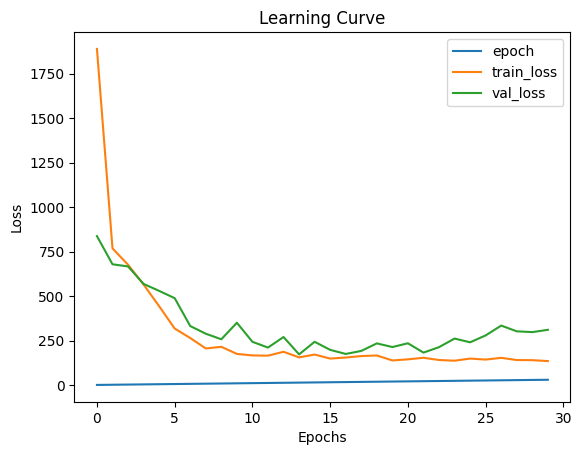

In [96]:
model_info = pd.read_csv(Path("models")/"prediction-model.csv")
df = pd.read_csv('models/prediction-model.csv', index_col=None)

table = df.plot()
table.set_title('Learning Curve')
table.set_ylabel('Loss')
table.set_xlabel('Epochs')
plt.show()